## Part c)

Implement now the variational quantum eigensolver (VQE) for the above
Hamiltonian and set up the circuit(s) which is(are) needed in order to find
the eigenvalues of this system. Discuss the results and compare these
with those from part b). Feel free to use either **Qiskit** or your own
code (based on the setup from part a)) or both approaches. Discuss
your results.

## The VQE algoritm

The VQE algorithm consists of several steps, partially done on a classical computer:
1. A parameterized ansatz for the quantum state is implemented on a quantum computer.

2. The ansatz is measured in a given measurement basis.

3. Postprocessing on a classical computer converts the measurement outcomes to an expectation value.

4. Classical minimization algorithms are used to up- date the variational parameters.

In [2]:
import qiskit as qk
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
from qiskit import transpile
from scipy.optimize import minimize_scalar, minimize

simulator = AerSimulator()

# define a function to create a ansatz wave function
# takes in a quantum circuit, applies the rotation around x by theta and then around y by phi
def ansatz(qc, qr, theta, phi):
    qc.rx(theta, qr[0])
    qc.ry(phi, qr[0])
    return qc
# define a function that makes measurements depending on what Operator should be measured
def measurements(qc, qr, cr, op):
    # measurement of Z operator. Nothing has to be changed, as our measurement basis are eigenstates of the operator
    if op == "Z":        
        # Measurement of qubit 0 on classical register 0
        qc.measure(qr[0],cr[0])
    # Measurement of X operator. Our measurement basis is not eigenstate of X, therfore we have to transform our 
    # measurement states with the Hadamard Gate.
    elif op == "X":
        # Change of basis, since X = HZH
        qc.h(qr[0])
        # Measurement of qubit 0 on classical register 0
        qc.measure(qr[0],cr[0])   
    return qc
# function for getting the energy by evaluating the expectation values of the hamiltonian. The expectation values
# are stored in a dictionary params#
def hamiltonian(params):
    e0 = 0.0; e1 = 4.0; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2
    c = (V11+V22)/2; omegaz = (V11-V22)/2; omegax = V12
    epsilon = (e0+e1)/2; Omega = (e0-e1)/2
    # H = (epsilon+c)*I+(omegaz+Omega)*Z+omegax*X
    en = (epsilon + c)*1 + (omegaz + Omega)*params["Z"] + omegax*params["X"]
    return en


def vqe_step(theta, phi, verbose = True):
    # Number of executions for each quantum circuit
    shots=10000
    
    vqe_res = dict()
    qc_list = dict()
    
    for op in ["X", "Z"]:
        qr = qk.QuantumRegister(1, "qr")
        cr = qk.ClassicalRegister(1, "cr")
        qc = qk.QuantumCircuit(qr, cr)

        # Implementation of the ansatz
        qc = ansatz(qc, qr, theta, phi)

        # Just for plotting purposes
        qc.barrier()

        # Measurements in the appropriate basis (X,Z) are implemented
        qc = measurements(qc, qr, cr, op)
                
        # Get the measurements results
        #counts = qk.execute(qc, simulator, shots=shots).result().get_counts()
        new_circuit = transpile(qc, simulator)
        job = simulator.run(new_circuit, shots = shots)
        counts = job.result().get_counts(qc)
        # Check the results, and evaluate the mean value dividing by the number of shots
        if len(counts) == 1: 
            try:
                counts['0']
                mean_val = 1
            except:
                mean_val = -1
        else:
            # Evaluates the mean value of Z operator, as the difference in the number of 
            # 0s and 1s in the measurement outcomes
            mean_val = (counts['0']-counts['1'])/shots
            
        vqe_res[op] = mean_val
        qc_list[op] = qc
        
    energy = hamiltonian(vqe_res)
    
    if verbose: 
        print("Mean values from measurement results:\n", vqe_res) 
        print(f"\n{'Theta':<10} {'Energy':<10} {'<X>':<10} {'<Z>':<10}")
        print(f"{theta:<10f} {energy:<10f} {vqe_res['X']:<10f} {vqe_res['Z']:<10f}")
    
        return energy, qc_list
    
    else: 
        return energy

# Measure the energy on the VQE functino for one set of angles to check functionality

In [3]:


# Set the value of theta
theta = 0.2
phi = 0.4

print("normal: ",vqe_step(theta, phi))
print("False: ", vqe_step(theta, phi, False))
# Run the VQE step to evaluate the energy (eigenvalue of the Hamiltonian) of the state with given theta
energy, qc_list = vqe_step(theta,phi)

# Plot the circuit used for the measurement of YY
op = 'X'
print(f"\nQuantum circuit for the measurement of {op}")
qc_list[op].draw()


Mean values from measurement results:
 {'X': 0.3702, 'Z': 0.8998}

Theta      Energy     <X>        <Z>       
0.200000   2.973840   0.370200   0.899800  
normal:  (2.97384, {'X': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021B7FD8EAB0>, 'Z': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021B3BDAC680>})
False:  2.97996
Mean values from measurement results:
 {'X': 0.3802, 'Z': 0.9114}

Theta      Energy     <X>        <Z>       
0.200000   2.987440   0.380200   0.911400  

Quantum circuit for the measurement of X


┌─────────┐┌─────────┐ ░ ┌───┐┌─┐
  qr: ┤ Rx(0.2) ├┤ Ry(0.4) ├─░─┤ H ├┤M├
      └─────────┘└─────────┘ ░ └───┘└╥┘
cr: 1/═══════════════════════════════╩═
                                     0

# Implement the gradient descent and check convergence

Eigenvalue with Numpy:  [3.0198039 0.9801961]
Minimum energy:  0.98488


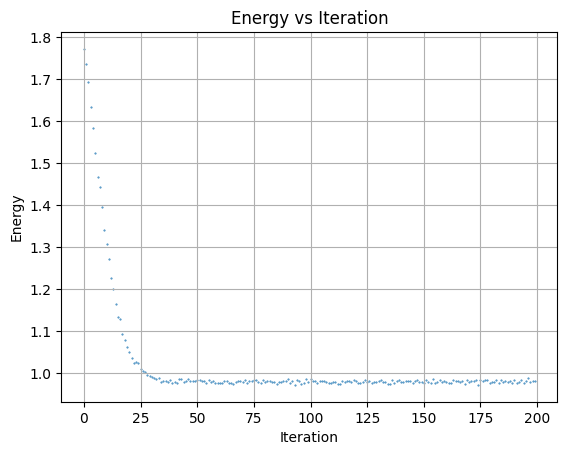

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate Eigenvalues with Pauli Matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])
e0 = 0.0; e1 = 4.0; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2
c = (V11 + V22) / 2; omegaz = (V11 - V22) / 2; omegax = V12
epsilon = (e0 + e1) / 2; Omega = (e0 - e1) / 2
H = (epsilon + c) * I + (omegaz + Omega) * Z + omegax * X
print("Eigenvalue with Numpy: ", np.linalg.eig(H)[0])

# Gradient descent parameters
eta = 0.05
Niterations = 200
energies = []

# Random angles using uniform distribution
theta = 2 * np.pi * np.random.rand()
phi = 2 * np.pi * np.random.rand()
pi2 = 0.3 * np.pi
# Perform gradient descent
for iter in range(Niterations):
    
    thetagradient = 1 / (pi2) * (vqe_step(theta + pi2, phi, False) - vqe_step(theta - pi2, phi, False))
    phigradient = 1 / (pi2) * (vqe_step(theta, phi + pi2, False) - vqe_step(theta, phi - pi2, False))
    theta -= eta * thetagradient
    phi -= eta * phigradient
    energy = vqe_step(theta, phi, False)
    energies.append(energy)
    #print("Iteration:", iter, "Energy:", energy)

print("Minimum energy: ", vqe_step(theta, phi, False))

# Plot the energy values
plt.scatter(range(Niterations), energies, s=0.2)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy vs Iteration')
plt.grid(True)
plt.show()

# CHeck energy surface in parameter space

In [5]:
import numpy as np
import plotly.graph_objects as go

resolution = 50
theta = np.linspace(0, 2*np.pi, resolution)
phi = np.linspace(0, 2*np.pi, resolution)
energies = np.zeros((resolution, resolution))

# Calculate energy values
for i in range(resolution):
    print(i)
    for j in range(resolution):
        energies[i, j] = vqe_step(theta[i], phi[j], False)

# Create 3D plot
fig = go.Figure(data=[go.Surface(z=energies, x=theta, y=phi)])

# Set labels and title
fig.update_layout(scene=dict(
                    xaxis_title='Theta',
                    yaxis_title='Phi',
                    zaxis_title='Energy',
                    ),
                    title='Energy of Hamiltonian')

# Show plot
fig.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Plot the energy over interaction strength for numpy and VQE eigenvalues

In [6]:
import qiskit as qk
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
from qiskit import transpile
from scipy.optimize import minimize_scalar, minimize

simulator = AerSimulator()

# define a function to create a ansatz wave function
# takes in a quantum circuit, applies the rotation around x by theta and then around y by phi
def ansatz(qc, qr, theta, phi):
    qc.rx(theta, qr[0])
    qc.ry(phi, qr[0])
    return qc
# define a function that makes measurements depending on what Operator should be measured
def measurements(qc, qr, cr, op):
    # measurement of Z operator. Nothing has to be changed, as our measurement basis are eigenstates of the operator
    if op == "Z":        
        # Measurement of qubit 0 on classical register 0
        qc.measure(qr[0],cr[0])
    # Measurement of X operator. Our measurement basis is not eigenstate of X, therfore we have to transform our 
    # measurement states with the Hadamard Gate.
    elif op == "X":
        # Change of basis, since X = HZH
        qc.h(qr[0])
        # Measurement of qubit 0 on classical register 0
        qc.measure(qr[0],cr[0])   
    return qc
# function for getting the energy by evaluating the expectation values of the hamiltonian. The expectation values
# are stored in a dictionary params#
def hamiltonian(params,V):
    e0 = 0.0; e1 = 4.0; V11 = 3*V; V22 = -3*V; V12 = 0.2*V; V21 = 0.2*V
    c = (V11+V22)/2; omegaz = (V11-V22)/2; omegax = V12
    epsilon = (e0+e1)/2; Omega = (e0-e1)/2
    # H = (epsilon+c)*I+(omegaz+Omega)*Z+omegax*X
    en = (epsilon + c)*1 + (omegaz + Omega)*params["Z"] + omegax*params["X"]
    return en


def vqe_step(theta, phi,V, verbose = True):
    # Number of executions for each quantum circuit
    shots=10000
    
    vqe_res = dict()
    qc_list = dict()
    
    for op in ["X", "Z"]:
        qr = qk.QuantumRegister(1, "qr")
        cr = qk.ClassicalRegister(1, "cr")
        qc = qk.QuantumCircuit(qr, cr)

        # Implementation of the ansatz
        qc = ansatz(qc, qr, theta, phi)

        # Just for plotting purposes
        qc.barrier()

        # Measurements in the appropriate basis (X,Z) are implemented
        qc = measurements(qc, qr, cr, op)
                
        # Get the measurements results
        #counts = qk.execute(qc, simulator, shots=shots).result().get_counts()
        new_circuit = transpile(qc, simulator)
        job = simulator.run(new_circuit, shots = shots)
        counts = job.result().get_counts(qc)
        # Check the results, and evaluate the mean value dividing by the number of shots
        if len(counts) == 1: 
            try:
                counts['0']
                mean_val = 1
            except:
                mean_val = -1
        else:
            # Evaluates the mean value of Z operator, as the difference in the number of 
            # 0s and 1s in the measurement outcomes
            mean_val = (counts['0']-counts['1'])/shots
            
        vqe_res[op] = mean_val
        qc_list[op] = qc
        
    energy = hamiltonian(vqe_res,V)
    
    if verbose: 
        print("Mean values from measurement results:\n", vqe_res) 
        print(f"\n{'Theta':<10} {'Energy':<10} {'<X>':<10} {'<Z>':<10}")
        print(f"{theta:<10f} {energy:<10f} {vqe_res['X']:<10f} {vqe_res['Z']:<10f}")
    
        return energy, qc_list
    
    else: 
        return energy

In [7]:
import numpy as np
import matplotlib.pyplot as plt
""" Do gradient descent for different interaction strengths
"""
# Calculate Eigenvalues with Pauli Matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])
e0 = 0.0; e1 = 4.0; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2
c = (V11 + V22) / 2; omegaz = (V11 - V22) / 2; omegax = V12
epsilon = (e0 + e1) / 2; Omega = (e0 - e1) / 2
H = (epsilon + c) * I + (omegaz + Omega) * Z + omegax * X
print("Eigenvalue with Numpy: ", np.linalg.eig(H)[0])

# Gradient descent parameters
eta = 0.05
Niterations = 200


# Random angles using uniform distribution

pi2 = 0.3 * np.pi
# Perform gradient descent
interactionStrengths = np.linspace(0,1,20)
eigenvaluesVQE = []
for V in interactionStrengths:
    theta = 2 * np.pi * np.random.rand()
    phi = 2 * np.pi * np.random.rand()
    energies = []
    print("Currently doin iteratin strength: ", V)
    for iter in range(Niterations):

        thetagradient = 1 / (pi2) * (vqe_step(theta + pi2, phi,V, False) - vqe_step(theta - pi2, phi,V, False))
        phigradient = 1 / (pi2) * (vqe_step(theta, phi + pi2,V, False) - vqe_step(theta, phi - pi2,V, False))
        theta -= eta * thetagradient
        phi -= eta * phigradient
        energy = vqe_step(theta, phi,V, False)
        energies.append(energy)
        #print("Iteration:", iter, "Energy:", energy)
    eigenvaluesVQE.append(min(energies))




Eigenvalue with Numpy:  [3.0198039 0.9801961]
Currently doin iteratin strength:  0.0
Currently doin iteratin strength:  0.05263157894736842
Currently doin iteratin strength:  0.10526315789473684
Currently doin iteratin strength:  0.15789473684210525
Currently doin iteratin strength:  0.21052631578947367
Currently doin iteratin strength:  0.2631578947368421
Currently doin iteratin strength:  0.3157894736842105
Currently doin iteratin strength:  0.3684210526315789
Currently doin iteratin strength:  0.42105263157894735
Currently doin iteratin strength:  0.47368421052631576
Currently doin iteratin strength:  0.5263157894736842
Currently doin iteratin strength:  0.5789473684210527
Currently doin iteratin strength:  0.631578947368421
Currently doin iteratin strength:  0.6842105263157894
Currently doin iteratin strength:  0.7368421052631579
Currently doin iteratin strength:  0.7894736842105263
Currently doin iteratin strength:  0.8421052631578947
Currently doin iteratin strength:  0.894736842

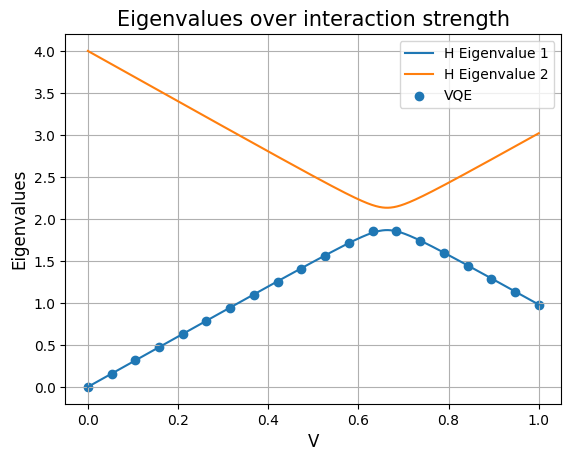

In [8]:
def H(V):
    return np.array([[0,0],[0,4]]) + V* np.array([[3,0.2],[0.2,-3]])
Vnumpy = np.linspace(0,1,1000)
eigenNumpy = []
# Compute eigenvalues for each value of V
for V in Vnumpy:
    # Compute eigenvalues for H2x2
    eigenNumpy.append(np.linalg.eigvalsh(H(V)))

# Convert lists to arrays for easier manipulation
eigenNumpy = np.array(eigenNumpy)

# Plot eigenvalues for H2x2
for i in range(2):
    plt.plot(Vnumpy, eigenNumpy[:, i], label=f'H Eigenvalue {i+1}')

# Plot the energy values
plt.scatter(interactionStrengths, eigenvaluesVQE,label ="VQE")
plt.xlabel('V', fontsize = 12)
plt.ylabel('Eigenvalues', fontsize = 12)
plt.title('Eigenvalues over interaction strength', fontsize = 15)
plt.grid(True)
plt.legend()
plt.savefig("PartCComparison.png")
plt.show()